In [1]:
!pip install git+https://github.com/qubvel/segmentation_models
!pip install h5py
!pip install imantics

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-a1hy3zos
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-a1hy3zos
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 1.4MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33791 sha256=2dc6303e949ef630d3c7dd662bdc29d51d6e259cecf7fb8160ed623369a0285a
  Stored in directory: /tmp/pip-ephem-wheel-cache-1yf88d2b/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Created wheel for imantics: filename=imantics-0.1.12-cp36-none-any.whl size=16034 sha256=d58d67ea59b25ef5d6552c5294d73753f5d0a4bc17def9c4ae8650eab47956b0
  Stored in directory: /root/.cache/pip/wheels/73/93/1c/9e2fc52eb74441941bc76cac441ddcc2c7ad67b18e1849e62a
Successfully built imantics


In [2]:
%tensorflow_version 1.x
from keras import utils
import keras_preprocessing.image.utils as image_utils
from keras.models import model_from_json
from PIL import Image
from imantics import Mask
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import skimage.io
import keras
import matplotlib.pyplot as plt
import cv2

TensorFlow 1.x selected.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Mounted at /content/drive


**Model loading**

In [3]:
WORKDIR = "src/Screen segmentation"
LR = 0.0007
json_file = open(WORKDIR +"/model/" + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(WORKDIR +"/model/" + "model.h5")
loaded_model.compile(keras.optimizers.Adam(LR),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Functions for image and mask visualizing**

In [4]:
groups = {'team_score1': 1, 'team_score2': 2, 'team_stat1' : 3, 'team_stat2' : 4, 'undefined' : 5}
def transform_mask(mask):
    mask = mask.squeeze()
    mask_layers = [(mask == klass) for klass in groups.values()]
    layered_mask = np.stack(mask_layers, axis=-1).astype('float')
    return layered_mask

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [6]:
filename = WORKDIR + "/datasets/validation/images/imgs/1.png"
img = cv2.imread(WORKDIR + "/datasets/validation/images/imgs/1.png")
mask = cv2.imread(WORKDIR + "/datasets/validation/masks/msks2/1.png")
mask = transform_mask(mask[...,0])

**Original image**

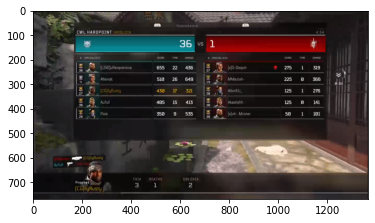

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

**Image with original masks(labeled in COCO annotator)**

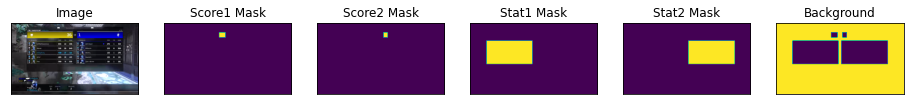

In [8]:
visualize(
            image=denormalize(img.squeeze()),
            score1_mask=mask[..., 0],
            score2_mask=mask[..., 1],
            stat1_mask=mask[..., 2],
            stat2_mask=mask[..., 3],
            background=mask[..., 4],
        )

**Image and mask resizing due to model input format**

In [9]:
image = cv2.resize(img, (256, 256))
mask = cv2.resize(mask, (256, 256))

**Making a prediction**

In [10]:
preds = loaded_model.predict(np.expand_dims(image, axis=0))
TRESHOLD = 0.7

In [11]:
fig = plt.figure(figsize=(100, 100))
r_masks = []
cropped_images = []
image = image_utils.load_img(filename)
img_array = image_utils.img_to_array(image)
for i in range(0, 5):
  mask_img = image_utils.array_to_img(preds[0][..., i, np.newaxis] > TRESHOLD)
  resized_mask = mask_img.resize((img_array.shape[1], img_array.shape[0]))
  resized_mask = image_utils.img_to_array(resized_mask)
  r_masks.append(resized_mask)

  resized_mask = Mask(resized_mask)
  bbox = resized_mask.bbox()
  cropped_image = image_utils.array_to_img(img_array[bbox[1]:bbox[3], bbox[0]:bbox[2]])
  cropped_images.append(cropped_image)

<Figure size 7200x7200 with 0 Axes>

**Image with predicted masks and cropped segments**

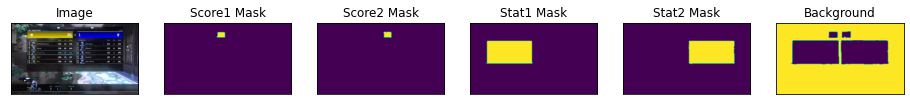

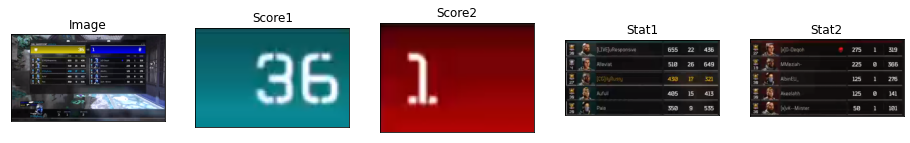

In [12]:
visualize(
            image=denormalize(img.squeeze()),
            score1_mask=r_masks[0][..., 0],
            score2_mask=r_masks[1][..., 0],
            stat1_mask=r_masks[2][..., 0],
            stat2_mask=r_masks[3][..., 0],
            background=r_masks[4][..., 0]
       )
visualize(
            image=denormalize(img.squeeze()),
            score1=cropped_images[0],
            score2=cropped_images[1],
            stat1=cropped_images[2],
            stat2=cropped_images[3]
        )